# Types of Recommendation Systems

Recommendation systems can be broadly classified into 3 types — 

1. Collaborative Filtering

2. Content-Based Filtering

3. Hybrid Recommendation Systems

# Table of Contents

<a id="toc"></a>
- [1. Set-up](#1)
    - [1.1 Import Libraries](#1.1)
    - [1.2 Import Data](#1.2)

- [2. Recommendation Systems](#2)
    - [2.1  Like/dislike Ranking (I don't like spinach)](#2.1)
    - [2.2  Weighted Ratings ](#2.2)
    - [2.3  Collaborative Filtering  ](#2.3)
        - [2.3.1 using Nearest Neighbors based on ratings ](#2.3.1)
        - [2.3.3 using Matrix Factorization via Singular Value Decomposition](#2.3.2)
    - [2.5  Content Based Filtering ](#2.5)



<a id="1"></a>
# <b>1 <span style='color:#F1A424'>|</span> Set-up</b>



<a id="1.1"></a>
## <b>1.1 <span style='color:#F1A424'>Import Libraries</span></b> 

In [1]:
import re, string, gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import nltk.corpus

In [2]:
# pandas configuration 
pd.set_option('display.max_colwidth', 100) # for automatic linebreaks and multi-line cells.
pd.set_option('display.max_columns', 100) 
pd.set_option('display.width', 1000)
# English stop words
STOPWORDS = set(nltk.corpus.stopwords.words('english')) 
# ignore future warnings
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="1.2"></a>
## <b>1.2 <span style='color:#F1A424'>Import Data</span></b> 

In [3]:
def get_data():
    df_recipes = pd.read_csv("../input/food-com-recipes-and-user-interactions//RAW_recipes.csv")
    df_interactions = pd.read_csv("../input/food-com-recipes-and-user-interactions/RAW_interactions.csv")
    df = pd.concat([df_recipes, df_interactions], axis=1, join='inner')
    return df

<a id="2"></a>
# <b>2 <span style='color:#F1A424'>|</span> Recommendation Systems</b>



<div style=" background-color:#3b3745;text-align:left; padding: 13px 13px; border-radius: 8px; color: white">
<ul>
<li> Like/dislike Ranking (I don't like spinach)
<li>There are 219129 rows
<li>Class is the target variable
<li>No missing values
</ul>
</div>

<a id="2.1"></a>
## <b>2.1 <span style='color:#F1A424'> Like/dislike Ranking (I don't like spinach)</span></b> 

The system removes items that the user explicitly disliked or boosts the score of fresher recipes.
Creating a network of recipes that includes the ingredients that you like, and ingredients that you don't like

In [4]:
df = get_data()

In [5]:
def convert_to_list(data):
    data = data.astype(str)
    data = data.str.lower()\
        .str.replace('[','')\
        .str.replace(']','')\
        .str.replace('\'','')\
        .str.replace("'", '')\
        .str.replace("-", ' ')\
        .str.split(', ')
    return data
df['ingredients'] = convert_to_list(df['ingredients'])
df['ingredients'][0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


['winter squash',
 'mexican seasoning',
 'mixed spice',
 'honey',
 'butter',
 'olive oil',
 'salt']

In [6]:
# let's define some polarising ingredients
hated_ingredients = ['winter squash', 'mexican seasoning', 'mixed spice', 'butter', 'olive oil', 'salt']
liked_ingredients = ['milk', 'vanilla', 'ice cream',"honey"]

# let's add a "rank" property
df['rank'] = 0 #pd.Series(0, index=np.arange(len(df)))
    
# populate data 
df['rank'] += df.ingredients.apply(lambda a: len(set(a) & set(liked_ingredients)))
df['rank'] -= df.ingredients.apply(lambda a: len(set(a) & set(hated_ingredients)))

df[['name', 'ingredients', 'rank']].head(10)

name                                                                                          ingredients  rank
0  arriba   baked winter squash mexican style                      [winter squash, mexican seasoning, mixed spice, honey, butter, olive oil, salt]    -5
1            a bit different  breakfast pizza                           [prepared pizza crust, sausage patty, eggs, milk, salt and pepper, cheese]     1
2                   all in the kitchen  chili  [ground beef, yellow onions, diced tomatoes, tomato paste, tomato soup, rotel tomatoes, kidney b...    -1
3                          alouette  potatoes  [spreadable cheese with garlic and herbs, new potatoes, shallots, parsley, tarragon, olive oil, ...    -2
4          amish  tomato ketchup  for canning       [tomato juice, apple cider vinegar, sugar, salt, pepper, clove oil, cinnamon oil, dry mustard]    -1
5                     apple a day  milk shake                                     [milk, vanilla ice cream, frozen apple juice concentrate, apple]     1
6                       aww  marinated olives  [fennel seeds, green olives, ripe olives, garlic, peppercorn, orange rind, orange juice, red chi...     0
7              backyard style  barbecued ribs  [pork spareribs, soy sauce, fresh garlic, fresh ginger, chili powder, fresh coarse ground black ...     0
8                    bananas 4 ice cream  pie  [chocolate sandwich style cookies, chocolate syrup, vanilla ice cream, bananas, strawberry ice c...     0
9                     beat this  banana bread  [sugar, unsalted butter, bananas, eggs, fresh lemon juice, orange rind, cake flour, baking soda,...    -1

In [7]:
del df
gc.collect()

55

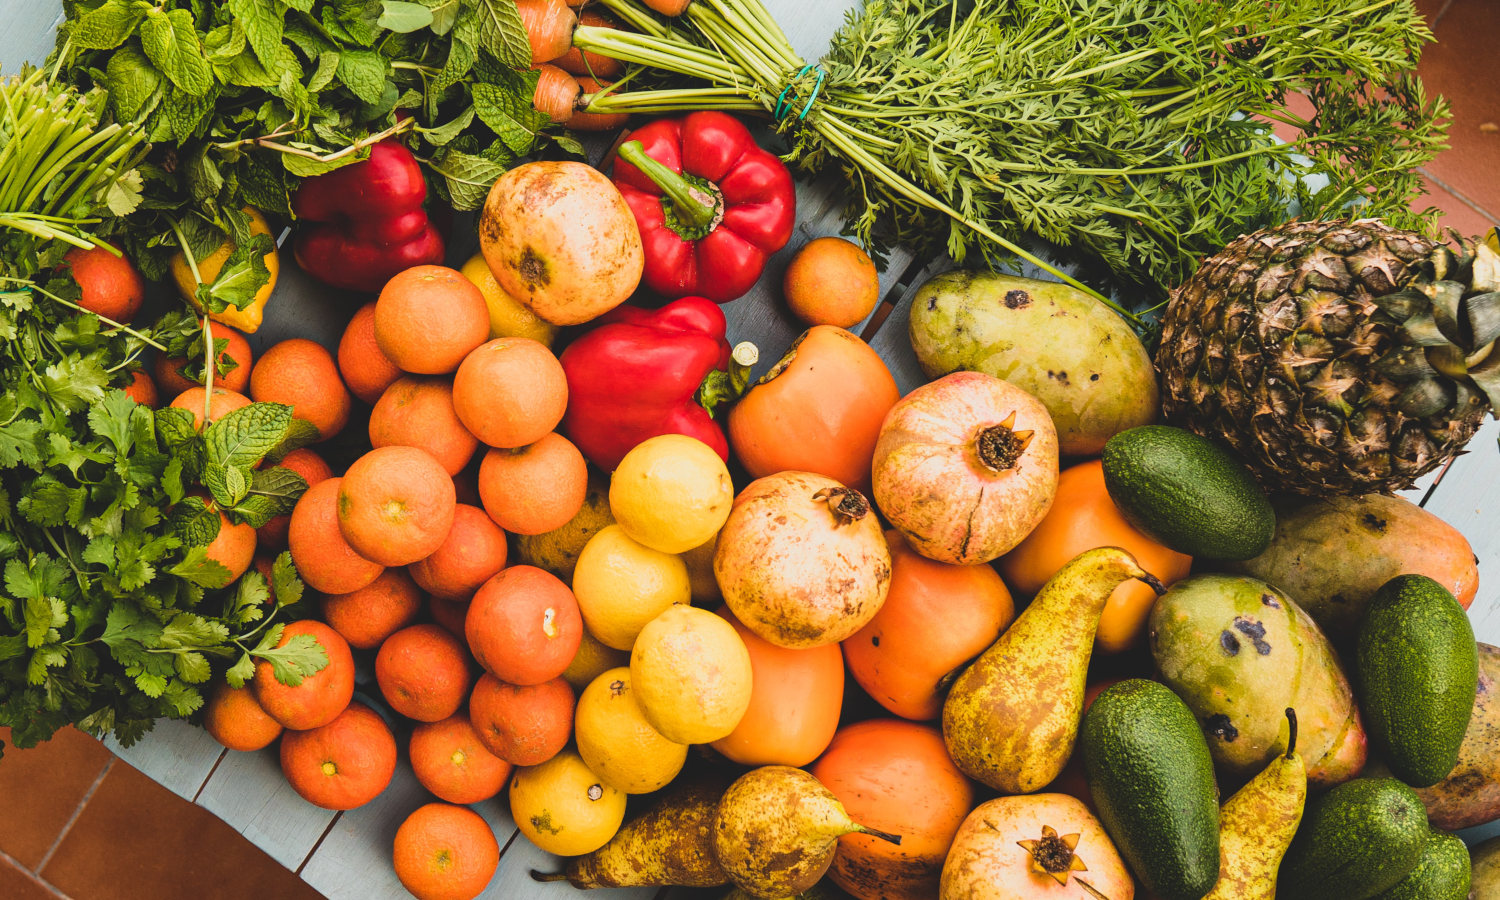

<a id="2.2"></a>
## <b>2.2 <span style='color:#F1A424'> Weighted Ratings</span></b> 

build a simple recommender that recommends food based on how much people have apprciated it

In [8]:
df = get_data()

In [9]:
recipe_rating_count = df.groupby('name')['rating']\
    .count()\
    .sort_values(ascending = False)\
    .reset_index()\
    .rename(columns={'rating':'Total_RatingCount'})
recipe_rating_count.head()

name  Total_RatingCount
0  the ultimate chocolate chip cookies                  3
1   gluten free chocolate chip cookies                  3
2            broccoli cauliflower soup                  3
3           broccoli cauliflower salad                  3
4       crock pot lemon garlic chicken                  3

In [10]:
df_votes = df.groupby(['recipe_id'])['rating']\
    .agg(['mean','count'])\
    .reset_index()\
    .rename(columns={'mean':'average_rating','count':'votes'})\
    .sort_values(by='average_rating', ascending = False)

df_votes.head()

recipe_id  average_rating  votes
23351     202184             5.0      1
27057     239486             5.0      1
27082     239774             5.0      1
27081     239764             5.0      2
27080     239761             5.0      2

Show the number of votes possesed by the top 10% meals, based on number of votes

In [11]:
df = pd.merge(df, df_votes, left_on='id', right_on='recipe_id')
df.drop(columns=['recipe_id_y'])
df.head(1)

name     id  minutes  contributor_id   submitted                                                                                                 tags                                  nutrition  n_steps                                                                                                steps                                                                                          description                                                                             ingredients  n_ingredients  user_id  recipe_id_x        date  rating                                                                                               review  recipe_id_y  average_rating  votes
0  a bit different  breakfast pizza  31490       30           26278  2002-06-17  ['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'o...  [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9  ['preheat oven to 425 degrees f', 'press dough into the bottom and sides of a 12 inch pizza pan'...  this recipe calls for the crust to be prebaked a bit before adding ingredients. feel free to cha...  ['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']              6  1293707        40893  2011-12-21       5  So simple, so delicious! Great for chilly fall evening. Should have doubled it ;)<br/><br/>Secon...        31490             3.5      4

Show the number of votes possesed by the top 10% meals, based on number of votes

In [12]:
q = df['votes'].quantile(0.9)
print(q)

9.0


### Calculation of weighted rating 

This function permits us to compute a special metric which takes into account the number of people
that have voted for a meal and not just it's average rating

In [13]:
def weighted_rating(df):
    """
     function permits us to compute a special metric which takes into account 
     the number of people that have voted for a meal and not just it's average rating
     Parameters:
         -----
         df: pandas datafram
    Return:
         -----
         Return weighted ratings
    """
    votes = df['votes']
    q_votes = df['votes'].quantile(0.9)
    mean_rarings = df['rating'].mean()
    avg_ratings = df['average_rating']
    return (votes/(votes+q_votes) * avg_ratings) + (q_votes/(q_votes+votes) * mean_rarings)

# Select top meals from Dataframe
df['Score'] = weighted_rating(df)

Sort best meals based on their scores

In [14]:
# Get meals which have received a substantial number of votes
top_meals = df.loc[df['votes']>=q]
print(top_meals.shape)
top_meals.head(1)

(5089, 21)


name     id  minutes  contributor_id   submitted                                                                                                 tags                                 nutrition  n_steps                                                                                                steps                                                                                          description                                                                                          ingredients  n_ingredients  user_id  recipe_id_x        date  rating                                                                                               review  recipe_id_y  average_rating  votes     Score
9  immoral  sandwich filling  loose meat  58224       35           37183  2003-04-04  ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'for-large-gr...  [223.2, 22.0, 4.0, 7.0, 35.0, 30.0, 0.0]        6  ['brown the meat & drain fat', 'stir in sugar , mustard , beer , cayenne , garlic and salt & pep...  just the thing for a day when you're wanton something delicious, and a hamburger patty is just t...  ['ground beef', 'sugar', 'prepared yellow mustard', 'beer', 'cayenne', 'garlic', 'salt & pepper'...              8   183565        79222  2006-02-13       5  Wow!  My family loves this recipe and it is a great winter meal.  I do have to say that I adjust...        58224             4.0     21  4.125487

In [15]:
top_meals = top_meals.sort_values('Score', ascending=False)
#Print the top 20 meals
top_meals[['name', 'votes', 'average_rating', 'Score']].head(20)

name  votes  average_rating     Score
7135     caprese salad tomatoes  italian marinated tomatoes     52        5.000000  4.914174
41793                          syrup for blueberry pancakes     57        4.964912  4.890373
4480                         berry cream cheese coffee cake     37        5.000000  4.886187
37848        simply irresistible tropical potato salad  sp5     74        4.932432  4.876682
2165                                   autumn chicken salad     41        4.975610  4.875292
19632                         greek yoghurt and fruit salad     36        4.972222  4.861436
12262                                  cranberry nut swirls     28        5.000000  4.858503
13682                           crunchy valley chicken  rsc     28        5.000000  4.858503
10068                  chocolate chip biscuits aussie style     35        4.971429  4.858287
10173                        chocolate covered strawberries     27        5.000000  4.854573
34055        quick and easy salsa with black beans and corn     32        4.968750  4.847917
45982                                       worm sandwiches     25        5.000000  4.846018
11473                                         colored sugar     31        4.967742  4.844115
636             all purpose mild brine for poultry and pork     43        4.930233  4.841627
39998  spring mix with walnuts  cranberries and goat cheese     24        5.000000  4.841352
35277                                          ritz cookies     24        5.000000  4.841352
6754                                       cafe mocha latte     23        5.000000  4.836394
14805                         double chocolate chip cookies     35        4.942857  4.835559
22210                                  huevos a la mexicana     35        4.942857  4.835559
45153                          wallumbilla crustless quiche     47        4.914894  4.835082

In [16]:
del df, top_meals
gc.collect()

69

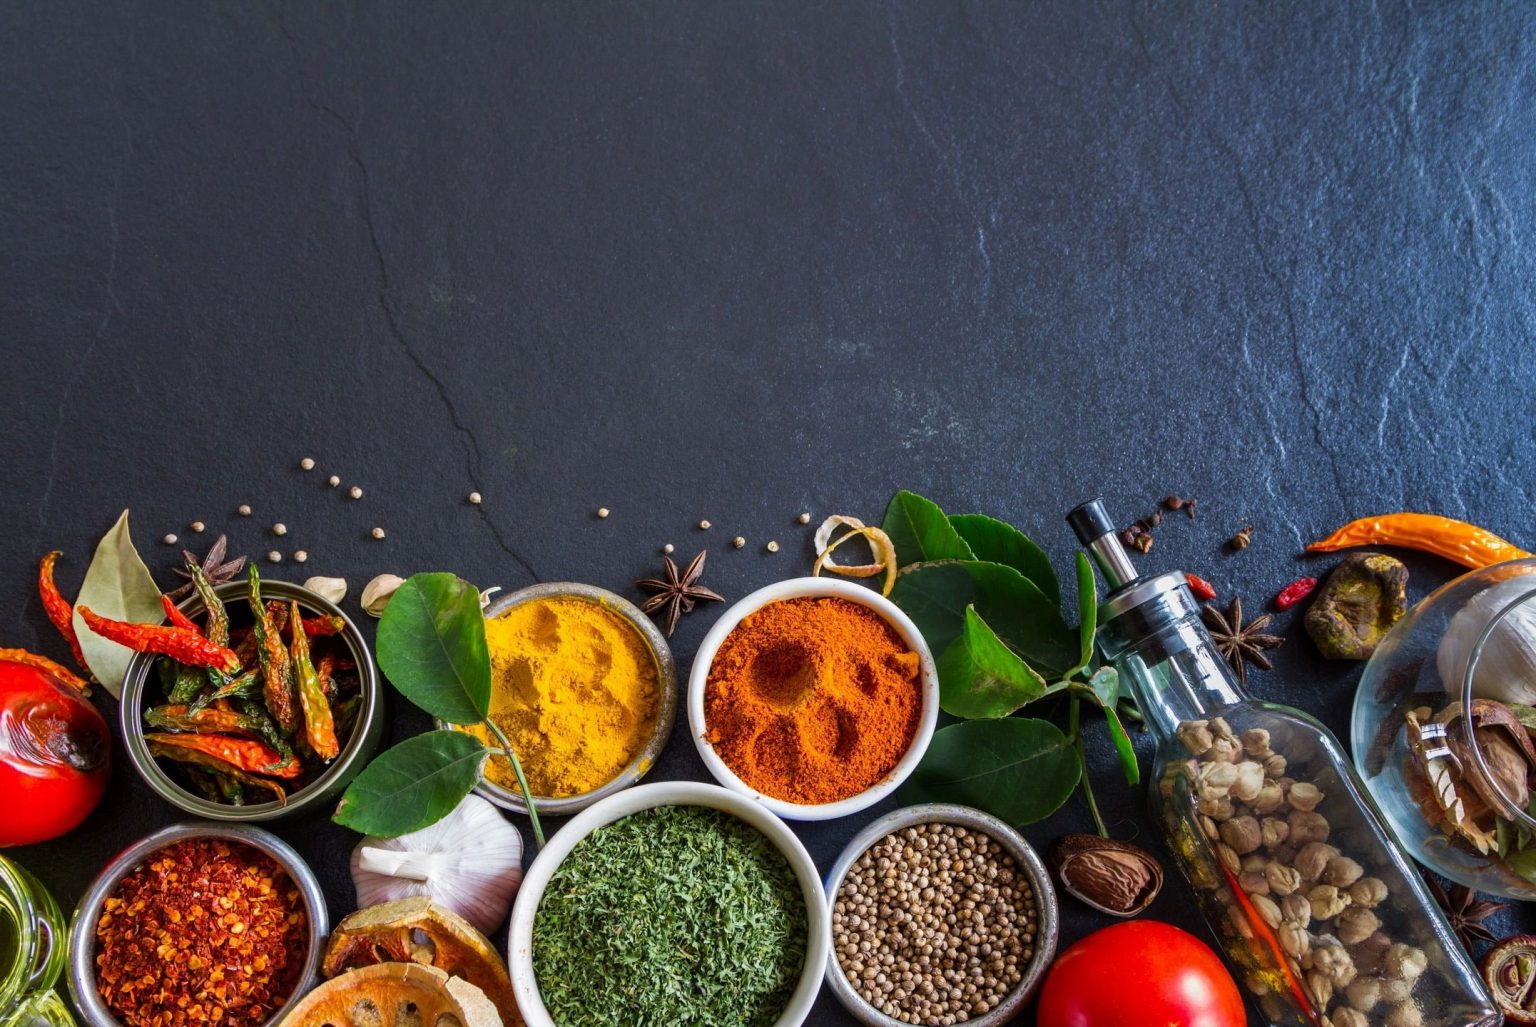

<a id="2.3"></a>
## <b>2.3 <span style='color:#F1A424'> Collaborative Filtering</span></b> 

<a id="2.3.1"></a>
## <b>2.3.1 <span style='color:#F1A424'> using Nearest Neighbors based on ratings</span></b> 

# Collaborative Filtering

- Collaborative filtering is making recommend according to combination of your experience and experiences of other people. 

- There are two collaborative filtering methods: User Based CF and Item Based CF

In [17]:
df = get_data()[:10000]

In [18]:
names = df.name
duplicated_names = df[
    names.isin(
        names[names.duplicated()]
    )
].sort_values(["name", "rating"], ascending= False)

duplicated_names.head(2)

name     id  minutes  contributor_id   submitted                                                                                                 tags                                  nutrition  n_steps                                                                                                steps                                                                                          description                                                                                          ingredients  n_ingredients  user_id  recipe_id        date  rating                                                                                               review
176  cream  of mushroom soup  50184       40           20477  2003-01-07  ['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', '...  [473.2, 59.0, 23.0, 7.0, 28.0, 36.0, 8.0]        8  ['in a 4 quart pot , saut the mushrooms in butter till tender', 'add garlic', 'saut on low heat ...  when i was vegan, i missed good cream soups. this one has an excellent, unique flavor. it isn't ...  ['mushrooms', 'margarine', 'garlic cloves', 'dry-roasted cashews', 'water', 'vegetable bouillon ...              9    61995     195977  2008-10-28       5  I have been making this for more than 10 years!  Mine is called "Neiman Marcus butter cake, sinc...
600  cream  of mushroom soup  51922       10           59064  2003-01-21  ['15-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'healthy', 'b...  [472.9, 64.0, 9.0, 38.0, 28.0, 19.0, 5.0]        3  ['place walnuts , garlic water , nama shoyu , and rosemary in blender and blend until creamy', '...  if you are not a raw food vegan then try this recipe with an open mind. raw foodists try not to ...    ['walnuts', 'garlic', 'water', 'shoyu', 'rosemary', 'flax seeds', 'mushroom', 'sliced mushrooms']              8    17803     383271  2010-05-10       5  I had white cornmeal on hand so was glad to find this recipe.  I used a 10" case iron skillet (1...

### Creating Pivot table
In the pivot table, the index will be 'name' of recipe ,columns will be 'contributor_id' and values in the table will be 'rating' of each user for the recipe.

Calculate the density of the rating matrix

>pivot_table = groupby + unstack

In [19]:
user_recipe_table = df.pivot_table(
    index = ["name"], # recipe_id, name
    columns = ["user_id"], # user_id, contributor_id
    values = "rating"
).fillna(0)
#user_recipe_table.fillna(user_recipe_table.mean(), axis=0, inplace=True)
user_recipe_table.head(10)

user_id                               1535        1676        2310        2312        2625        3288        3385        3678        4005        4291        4439        4470        4740        4796        5060        5061        5672        5684        5903        6258        6357        6418        6512        6651        6688        6836        7108        7119        7308        7802        7978        8000        8377        8606        8629        8688        8937        9466        9580        9869        10033       10113       10332       10404       10701       10979       11044       11176       11297       11461       ...  2002133271  2002138213  2002138361  2002142414  2002156787  2002158749  2002172815  2002173387  2002180927  2002181810  2002182126  2002187419  2002188457  2002192418  2002195500  2002195734  2002204484  2002204609  2002205107  2002205149  2002211716  2002212968  2002215452  2002221814  2002234217  2002238605  2002241285  2002245801  2002259965  \
name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          ...                                                                                                                                                                                                                                                                                                                                                               
0 carb   0 cal gummy worms                   0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0  ...         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0   
0 fat chunky watermelon salsa                0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0  ...         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0         0.0   
0 point ice cream  only 1 in

Choose random recipe.

In [20]:
random_recipe_index = np.random.choice(user_recipe_table.shape[0])
random_recipe = user_recipe_table.index[random_recipe_index]

print("Random recipe index is: ", random_recipe_index)
print("Random recipe is: ", random_recipe)

Random recipe index is:  2959
Random recipe is:  almond coconut 3 layer cake with coconut frosting


In [21]:
model_knn = NearestNeighbors(
    n_neighbors = 1000,
    metric = 'cosine', 
    algorithm = 'brute'
)
model_knn.fit(user_recipe_table)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=1000)

In [22]:
distances, indices = model_knn.kneighbors(
    user_recipe_table.iloc[random_recipe_index, :].values.reshape(1, -1), 
    n_neighbors = 10
)

In [23]:
distances, indices = distances.flatten(), indices.flatten()
distance, recipe = [], []

In [24]:
for i in range(0, len(distances)):
    if i != 0:
        recipe.append(user_recipe_table.index[i])
        distance.append(distances[i])   

Recommendations for random recipe are:

In [25]:
recommend = pd.DataFrame(
    {
        'recipe': recipe, 
        'distance': distance
    }
).sort_values('distance', ascending=False)
recommend.reset_index(drop=True, inplace=True)

print(f'Recommendations for {random_recipe}:-')
display(recommend)

Recommendations for almond coconut 3 layer cake with coconut frosting:-


recipe  distance
0         0 fat chunky watermelon salsa       1.0
1  0 point ice cream  only 1 ingredient       1.0
2                     0 point soup   ww       1.0
3               0 point soup  crock pot       1.0
4                          007  martini       1.0
5                          007 cocktail       1.0
6   1  2  3  swiss meringue buttercream       1.0
7             1 00 tangy chicken recipe       1.0
8                1 000 artichoke hearts       1.0

<a id="2.3.2"></a>
## <b>2.3.2 <span style='color:#F1A424'> using Matrix Factorization via Singular Value Decomposition</span></b> 

Matrix factorization is the breaking down of one matrix into a product of multiple matrices. It’s extremely well studied in mathematics, and it’s highly useful. There are many different ways to factor matrices, but singular value decomposition is particularly useful for making recommendations.

In [26]:
from scipy.sparse.linalg import svds

In [27]:
R = user_recipe_table.to_numpy() # values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

# Singular Value Decomposition
U, sigma, Vt = svds(R_demeaned, k = 50)
# convert sigma to the diagonal matrix form
sigma = np.diag(sigma)

Making Predictions from the Decomposed Matrices

In [28]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
predictions_df = pd.DataFrame(
    all_user_predicted_ratings, 
    columns = user_recipe_table.columns,
    index = user_recipe_table.index
)

In [29]:
sorted_user_predictions = predictions_df.iloc[random_recipe_index].sort_values(ascending=False)[:10]
sorted_user_predictions

user_id
6357      0.000833
428885    0.000817
179133    0.000817
394077    0.000803
573325    0.000803
844554    0.000803
5060      0.000801
95743     0.000798
353579    0.000798
101823    0.000798
Name: almond coconut 3 layer cake with coconut frosting, dtype: float64

Recommendations for random recipe are:

In [30]:
df[df.user_id.isin(sorted_user_predictions.index.tolist())]['name'][:10]

21            cream  of spinach soup  vegan
32                     grilled  ranch bread
44            italian sandwich  pasta salad
211    i thought i had nothing to eat  rice
371                 duffins   donut muffins
407     healthified  decadent hot chocolate
414              homemade  hamburger helper
446                         lite  tortillas
504            pita the great    tuna salad
557                those  chocolate cookies
Name: name, dtype: object

In [31]:
del df, user_recipe_table, recommend, distances, indices, names, duplicated_names
gc.collect()

161

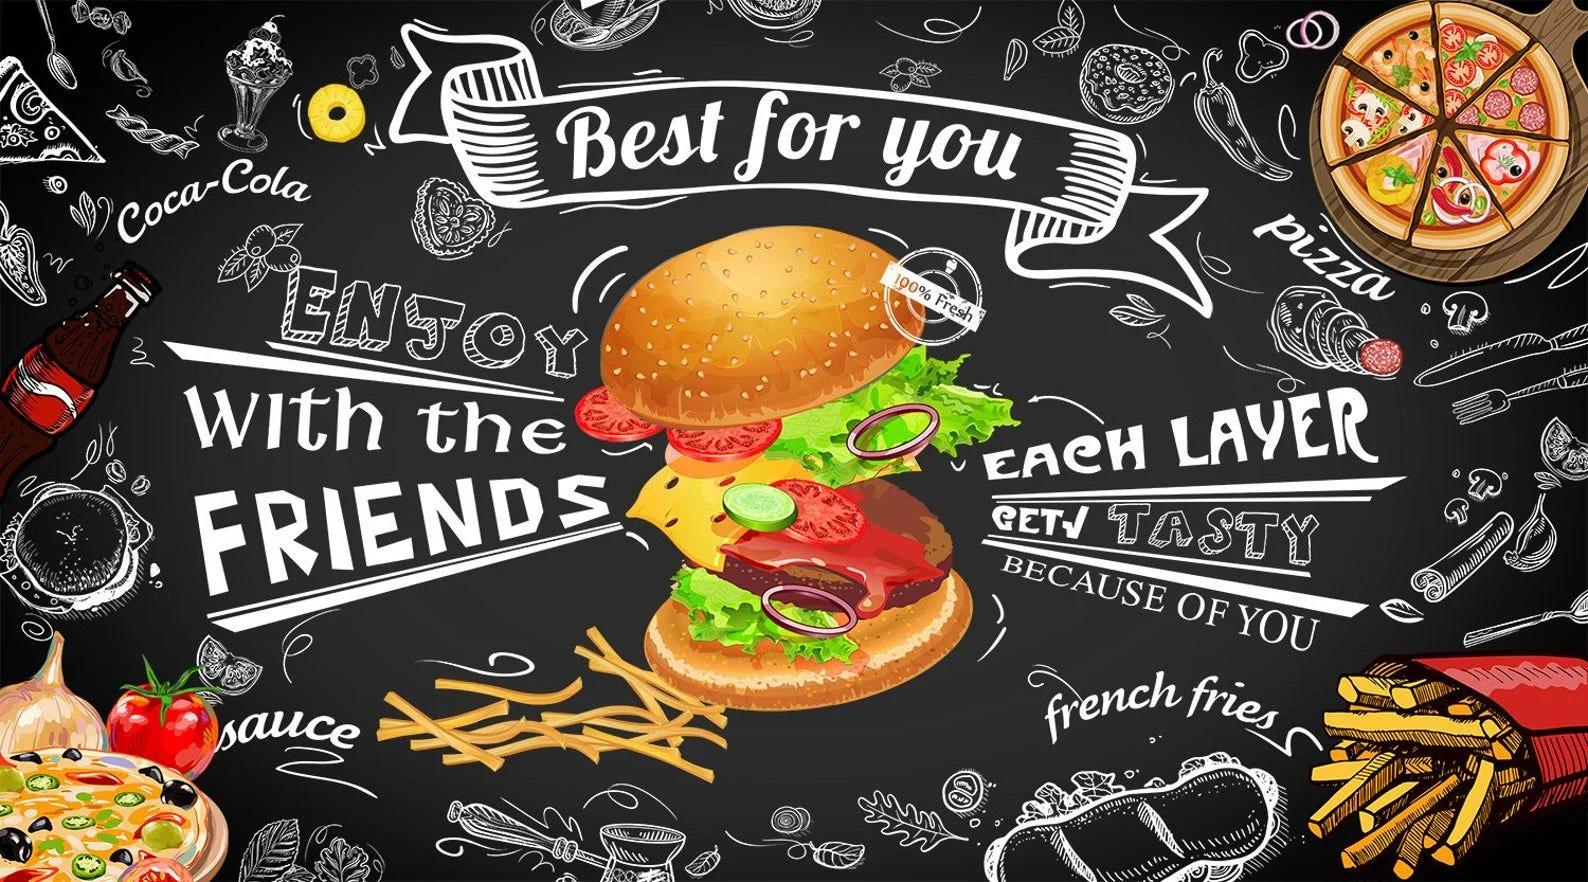

<a id="2.5"></a>
## <b>2.5 <span style='color:#F1A424'> Content Based Filtering</span></b> 

In [32]:
# ## Take a sample from data set
df = get_data()[:10000]

In [33]:
df['text'] = df[['ingredients', 'review']].astype(str).agg(' '.join, axis=1)

In [34]:
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 
# Some HTML texts can also contain entities that are not enclosed in brackets, such as '&nsbm'.
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

In [35]:
def remove_punctuation(text)->str:
    """
    Parameters:
        ----
        test: string
    Return:
        ----
        A text after removing punctuation.
    """
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [36]:
def preprocessing(sentence, stem=None)->str:
    """
        Parameters
        ----------
        sentence : String
    Return: 
        ----------
        The sentence after applying diffrent preprocessing methods.
    """
    #if type(sentence) is not str: 
    #    print(sentence)
    #assert( type(sentence) is str )
    sentence = str(sentence)
    # Converting to lowercase
    sentence = sentence.lower() 
    # Removing HTML tags
    sentence = cleanhtml(sentence)      
    # Removing Punctuations
    #sentence = re.sub(r'[?|!|\'|"|#]', r'',sentence)
    #sentence = re.sub(r'[.|,|)|(|\|/]', r' ',sentence)      
    sentence = remove_punctuation(sentence)
    
    if stem == 'stem':
    # Stemming and removing stopwords
        snow = nltk.stem.SnowballStemmer('english')
        words = [snow.stem(word) for word in sentence.split() if word not in STOPWORDS] 
    elif stem == 'lemmatize':
        # WordNetLemmatizing
        lemmatizer = nltk.stem.WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in sentence.split() if word not in STOPWORDS] 
    else: 
        words = [word for word in sentence.split() if word not in STOPWORDS] 
        
    # Remove dublicated words
    sentence = " ".join(sorted(set(words), key=words.index))
    return sentence

df['text'] = df['text'].apply(preprocessing)
df[['name', 'text']]

name                                                                                                 text
0      arriba   baked winter squash mexican style  winter squash mexican seasoning mixed spice honey butter olive oil salt great salad cooked top s...
1                a bit different  breakfast pizza  prepared pizza crust sausage patty eggs milk salt pepper cheese simple delicious great chilly fa...
2                       all in the kitchen  chili  ground beef yellow onions diced tomatoes tomato paste soup rotel kidney beans water chili powder...
3                              alouette  potatoes  spreadable cheese garlic herbs new potatoes shallots parsley tarragon olive oil red wine vinegar...
4              amish  tomato ketchup  for canning  tomato juice apple cider vinegar sugar salt pepper clove oil cinnamon dry mustard made cheddar b...
...                                           ...                                                                                                  ...
9995         asparagus with mustard seed dressing  asparagus whole mustard seeds lemon juice white vinegar dijon excellent used red bell peppers ad...
9996  asparagus with no cook creamy mustard sauce  plain nonfat yogurt light mayonnaise dijon mustard lemon juice salt water asparagus spears black...
9997                 asparagus with nutmeg butter  asparagus spears butter lemon nutmeg salt freshly ground black pepper decribed spicy much health...
9998             asparagus with olive oil   herbs  fresh parsley garlic extra virgin olive oil asparagus salt pepper mint lemon juice spicy healthy...
9999            asparagus with orange curry sauce  mayonnaise plain yogurt orange juice zest curry powder asparagus wow easy prepare first time ive...

[10000 rows x 2 columns]

Get a random recipe name sample.

In [37]:
sample_recipe_index = np.random.randint(len(df))
sample_recipe = df['name'][sample_recipe_index]
sample_recipe

'hershey s special dark  chocolate chip cookies'

To determine the degree of similarity, most recommendation systems rely on one or more of the following:

* cosine
* dot product
* Euclidean distance

The Cosine similarity score is used since it is independent of magnitude and is relatively easy and fast to calculate.

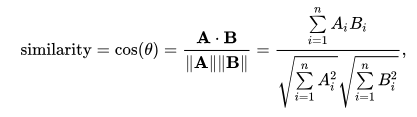

In [38]:
def recipes_similarity(df):
    """
    """
    feature = df.text.tolist()
    tfidf = TfidfVectorizer(input=feature, stop_words="english")
    tfidf_matrix = tfidf.fit_transform(feature)
    similarity = cosine_similarity(tfidf_matrix)
    return similarity

similarity = recipes_similarity(df)

In [39]:
def recipes_recommendation(name, df=df, similarity=similarity):
    """
        Parameters
        ----------
        name : String
        df: pandas DataFrame
        similarity: List
    Return: 
        ----------
        The recommendation list.
    """
    indices = pd.Series(df.index, index=df.name).drop_duplicates()
    index = indices[name]
    similarity_scores = list(enumerate(similarity[index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[0:10]
    restaurantindices = [score[0] for score in similarity_scores]
    recommend_list = df['name'].iloc[restaurantindices].tolist()
    return recommend_list

In [40]:
print(f"Recommendation Recipies for \'{sample_recipe}\' are :-\n")
print(*recipes_recommendation(sample_recipe, df), sep='\n')

Recommendation Recipies for 'hershey s special dark  chocolate chip cookies' are :-

hershey s special dark  chocolate chip cookies
always perfect chocolate chip cookies
all american chewy chocolate chip cookies
apple cinnamon bars
adams ginger snappys
american choc chip cookies of death
aloha chippers
addicting chocolate chip cookies
healthy  5 minute mug cake
1 bowl fudgy brownies
